In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

# 単語埋め込み

単語をベクトルに関連づける方法の一つ。密な単語ベクトル。one-hotで得られるベクトルは高次元の２値の疎ベクトル。次元の数は語彙の単語の数と同じで、ほぼ０が入る。    

これに対して単語埋め込みは、浮動小数点数型の低次元の密ベクトル。one-hotにすると20000次元以上に変換されるが、埋め込みベクトルでは256、512あるいは1024次元になる。埋め込みベクトルの方が少ない次元で多くの情報を格納する。



![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

単語埋め込みを取得する方法２つの紹介。    

- メインタスク（文章分類や感情予測など）と同時に単語埋め込みを学習    

- 別のタスクで計算された埋め込みベクトルを使う    



## 埋め込み層を使った単語埋め込みの学習

単語を密ベクトルに関連づけるもっとも単純な方法は、ベクトルをランダムに選択すること。このアプローチの問題は、結果の埋め込み空間が構造的ではないこと。単語"accurate"と"exact"を同じ意味で使用できるにも関わらず、埋め込みは全く異なるものになる。そうしたノイズだらけの構造化されてない埋め込み空間を理解するのは困難。    
単語ベクトル同士の幾何学的な関係は、それらの単語の意味的な関係を反映したものである必要がある。埋め込み空間の距離は単語の意味の距離に比例してほしい。埋め込みベクトルではさらに距離に向きを加える。



In [0]:
from keras.layers import Embedding

# Embedding層の必須引数は２つ
#有効なトークン数：この場合は1000(1+単語のインデックスの最大値)
#埋め込みの次元数：この場合64
embedding_layer = Embedding(1000, 64)

Embedding層については単語のインデックスをみつベクトルにマッピングするディクショナリと考えられる。この層は入力として整数を受け取り、内部のディクショナリ検索し、整数に関連づけられてるベクトルを返す。         

単語インデックス→埋め込み層→対応する単語ベクトル    

同じバッチに含まれているシーケンスは１つのテンソルにまとめる必要がるので、同じ長さ出ない場合はパディングしたり切り捨てたりする。

入力shape：(samples, sequence_length)    
出力shape：(samples, sequence_length, embedding_dimensionality)    
の３階テンソルなので出力層はCNNかRNNに結合できる。


IMDb映画レビューデータの感情予測タスクに当てはめる。load_dataの引数を指定して出現頻度が高い10000個の単語に映画レビューを絞り込み。20個の単語以外切り捨てる。    
ネットワークは10000個の単語ごとに８次元の単語埋め込みを学習。入力である整数シーケンス（２次元のテンソル）を埋め込みシーケンス（３次元のテンソル）に変換。テンソルを２次元に平坦化。Dense層で最終層に結合。

In [3]:
from keras.datasets import imdb
from keras import preprocessing

#特徴量として考慮する単語の数
max_features = 10000
#max_features個の最も出現頻度の高い単語のうちmax_len数の単語を残してカット
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(x_train.shape)
print(y_train.shape)

17465344/17464789 [==============================] - 1s 0us/step
(25000,)
(25000,)


上のshapeはnumpy.arrayになってないと見れない。    
そして(25000,)てなってて(25000,100)てなってないのは可変の次元になってるせい。

In [4]:
print(len(x_train[0]))
print(len(x_train[1]))

218
189


In [5]:
#シーケンスをある設定した20で切り捨ててる。
#整数のリストを形状が(samples, max_len)の整数型の２次元テンソルに変換
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(25000, 20)
(25000, 20)


In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding

model = Sequential()
#後から埋め込み入力を平坦化できるように、
#Embedding層に入力の長さmax_lenの20を指定。
model.add(Embedding(10000, 8, input_length=maxlen))
# 埋め込みの３次元テンソルを２次元に変換 `(samples, maxlen * 8)`
model.add(Flatten())

# 分類器を追加
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 231us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
11904/20000 [================>.............] - ETA: 1s - loss: 0.5853 - acc: 0.7410

20000/20000 [==============================] - 4s 185us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 4s 183us/step - loss: 0.4752 - acc: 0.7808 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
20000/20000 [==============================] - 4s 183us/step - loss: 0.4263 - acc: 0.8077 - val_loss: 0.5008 - val_acc: 0.7452
Epoch 5/10
20000/20000 [==============================] - 4s 188us/step - loss: 0.3930 - acc: 0.8258 - val_loss: 0.4981 - val_acc: 0.7538
Epoch 6/10
13088/20000 [==================>...........] - ETA: 1s - loss: 0.3638 - acc: 0.8418

20000/20000 [==============================] - 4s 187us/step - loss: 0.3668 - acc: 0.8395 - val_loss: 0.5014 - val_acc: 0.7530
Epoch 7/10
20000/20000 [==============================] - 4s 187us/step - loss: 0.3435 - acc: 0.8533 - val_loss: 0.5052 - val_acc: 0.7520
Epoch 8/10
20000/20000 [==============================] - 4s 188us/step - loss: 0.3223 - acc: 0.8657 - val_loss: 0.5132 - val_acc: 0.7486
Epoch 9/10
20000/20000 [==============================] - 4s 186us/step - loss: 0.3022 - acc: 0.8766 - val_loss: 0.5213 - val_acc: 0.7490
Epoch 10/10
12896/20000 [==================>...........] - ETA: 1s - loss: 0.2851 - acc: 0.8866

20000/20000 [==============================] - 4s 183us/step - loss: 0.2839 - acc: 0.8860 - val_loss: 0.5303 - val_acc: 0.7466


検証データ正解率が76%。悪くない数字。埋め込みシーケンスを平坦化してDense層を追加しているのに注意。そのため最終的なモデルは、入力を処理し、単語同士の関係や意味的な構造を考慮に入れない。    
さらに良いのは埋め込みシーケンスの最後にリカレント層か１次元の畳み込み層を追加して、各シーケンスを全体的に考慮する特徴量を学習する方法。

## 学習済みの単語埋め込みの使用




教師データが足りない場合は、他のデータセットで学習したものを再利用することもできる。


## テキストのトークン化から単語埋め込みまで


学習済みの単語埋め込みを使用する。
IMDbデータを使用する代わりに、元のテキストデータをダウンロードしてテキストをトークン化するところから始める。

### IMDBデータをテキストとしてダウンロード


訓練に使用する個々の映画レビューを文字列のリストにまとめます。リスト(texts)にはレビューごとに文字列が１つ含まれる。映画レビューのラベル(肯定的、否定的)をlabelsリストにまとめる。    

http://ai.stanford.edu/~amaas/data/sentiment/


In [7]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2018-06-23 22:43:37--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  11.2MB/s    in 7.1s    

2018-06-23 22:43:44 (11.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
# !tar -zxvf aclImdb_v1.tar.gz

In [0]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [10]:
print(labels[:2])
print(texts[:2])

[0, 0]
["I wanted to watch this movie because of Eliza Dushku, but she only has a smaller part in it, and her character isn't very likable. However, the main character, played by Melissa Sagemiller, is extremely beautiful and a perfect delight to look at throughout the movie. This is really nothing but a showcase for her looks and talent. She does a very good job.<br /><br />The story itself is, on the face of it, pretty nonsensical. After a car crash, some friends are possibly dead, but keeps on living their previous lives, while all sorts of mysterious things happen. Some bad guys are after them, but we never really find out who they are (possibly they were the ones in the other car, but we certainly don't hear anything about why they are after them). The final scenes especially seem filmically ambitious, but I can't get anything coherent out of it. The opening scene, where the bad guys (who wear some strange masks) cut a blond girl's wrist and gather up some of her blood is never ex

リストに全件溜め込んで行くとデータが多くなるとメモリで死ぬかもしれない。数件ごとにシリアライズしてみる

簡単なリストを数件ごとに分割する

In [11]:
# a = range(15)
# [list(a[i:i+3]) for i in range(0,15,3)]

b = [1,2,3,4,5,6,7,8,9]
print([i for i in range(len(b))])
print([b[i:i+3] for i in range(len(b))])
print([b[i:i+3] for i in range(0, len(b), 3)])#3件ごとに

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9], [9]]
[[1, 2, 3], [4, 5, 6], [7, 8, 9]]


In [12]:
list1 = ['a', 'b', 'c']
for (i, x) in enumerate(list1):
    print(i,x)

0 a
1 b
2 c


In [13]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

dic_labels = {}
dic_texts = {}
l_labels = []
l_texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    fnames = os.listdir(dir_name)
    fnames = [fnames[i:i+1000] for i in range(0, len(fnames), 1000)]
    for (fname_index, spalated_fnames) in enumerate(fnames):
        for fname in spalated_fnames:
            
            if fname[-4:] == '.txt':
                f = open(os.path.join(dir_name, fname))
                l_texts.append(f.read())
                f.close()
                if label_type == 'neg':
                    l_labels.append(0)
                else:
                    l_labels.append(1)
        dic_texts[label_type+str(fname_index)] = l_texts
        dic_labels[label_type+str(fname_index)] = l_labels
        l_labels = []
        l_texts = []
                    
print(dic_texts.keys())

dict_keys(['neg0', 'neg1', 'neg2', 'neg3', 'neg4', 'neg5', 'neg6', 'neg7', 'neg8', 'neg9', 'neg10', 'neg11', 'neg12', 'pos0', 'pos1', 'pos2', 'pos3', 'pos4', 'pos5', 'pos6', 'pos7', 'pos8', 'pos9', 'pos10', 'pos11', 'pos12'])


In [14]:
print(dic_labels["neg0"])
print(dic_labels["pos0"])
print(dic_texts["neg0"][:1])
print(dic_texts["pos0"][:1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

こうやって分割しておけばバッチサイズごとにリストを生成して学習できる。ファイルパスもメモリに保持したくない場合はそこもファイルに保存するのもあり。

### データのトークン化

テキストをベクトル化して、訓練データセットと検証データセットに分割。



In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 英語レビューを１００ワードでカット
training_samples = 200  # 200個のサンプルで訓練
validation_samples = 10000  # 10000個のサンプルで検証
max_words = 10000  # データセットの最初から10000ワードのみを考慮

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [16]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [17]:
#データを訓練データセットと検証データセットに分割。
indices = np.arange(data.shape[0])
np.random.shuffle(indices) #データをシャッフル
print("indices", indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

indices [22282 13399 14741 ...  9175  5922 12766]


In [18]:
print(labels)
print(y_train)

[1 1 1 ... 0 0 1]
[1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1
 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0
 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1
 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1]


### GloVeの単語埋め込みをダウンロード


https://nlp.stanford.edu/projects/glove/
    
2014年の英語のwikiデータを使って学習した埋め込みをダウンロード。    
ファイル名はglove.6B.zipで822MBで、40万語の単語で100次元の埋め込みベクトル。


In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2018-06-23 22:44:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-06-23 22:44:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  40.3MB/s    in 22s     

2018-06-23 22:44:50 (37.6 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [20]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [21]:
!ls

aclImdb		   datalab	      glove.6B.200d.txt  glove.6B.50d.txt
aclImdb_v1.tar.gz  glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip


### 埋め込みの前処理

展開したファイル.txtファイルから単語をベクトルにマッピングするインデックスを構築。    
単語と100次元の埋め込みベクトルが格納されてる。

In [22]:
glove_dir = './'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    print(values)
    print(len(values)) #単語プラス＋100次元の埋め込みベクトル
    break

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

In [23]:
#GloVeの単語埋め込みファイルを確認
#embeddings_indexに単語辞書を作る

import numpy as np
glove_dir = './'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


embedding層に読み込む埋め込み行列を作成。    
この行列の形状は(max_words, 
embedding_dim)。各エントリiにはインデックスiの単語に対応するembedding_dim次元ベクトル。


In [0]:
#GloVeの単語埋め込み行列の準備
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### モデルの定義

以前のモデルと同じ。

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### GloVeの埋め込みモデルに読み込む

Embedding層の重み行列は浮動小数点型の２次元行列で、各エントリiはインデックスiに関連づけられる単語。GloVe行列用のベクトルをモデルに読み込む。


In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

embeddingのtrainableをFalseにして凍結する。ランダムに初期化された層によって勾配の大きな更新が伝播されれば、学習済みの特徴量は破壊される。

### モデルの訓練と評価

Let's compile our model and train it:

In [27]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 2.2486 - acc: 0.5150 - val_loss: 1.7480 - val_acc: 0.5064
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6381 - acc: 0.7350 - val_loss: 0.7559 - val_acc: 0.5309
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4492 - acc: 0.7600 - val_loss: 0.7039 - val_acc: 0.5548
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2054 - acc: 0.9600 - val_loss: 0.7369 - val_acc: 0.5606
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1577 - acc: 0.9550 - val_loss: 1.1430 - val_acc: 0.5030
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1980 - acc: 0.9050 - val_loss: 0.7341 - val_acc: 0.5796
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0517 - acc: 1.0000 - val_loss: 1.0589 - val_acc: 0.5154
Epoch 8/10
200/200 [========

Let's plot its performance over time:

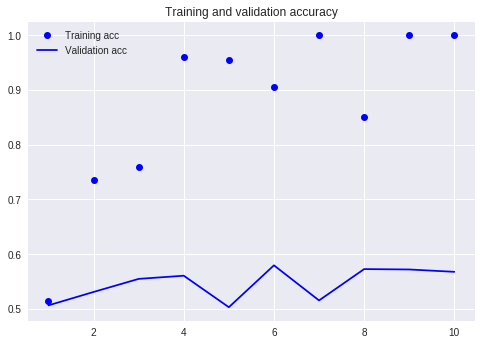

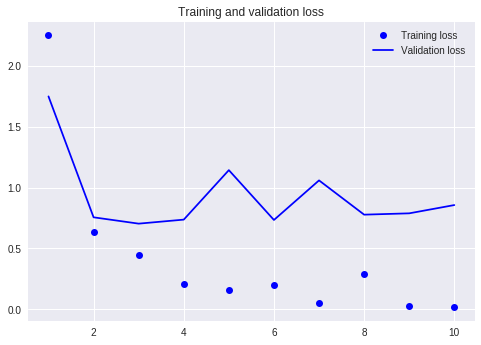

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

このモデルはすぐに過学習になってる。valのaccが上がっていってる。    
訓練に使用したサンプル数が少ない。訓練データは500個をランダムで取得するので性能が変化する。    
埋め込みベクトルを読み込まずに学習してみる


In [29]:
#学習済みの単語埋め込みを使用せずに同じモデルを学習
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6906 - acc: 0.5100 - val_loss: 0.6936 - val_acc: 0.5063
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4761 - a

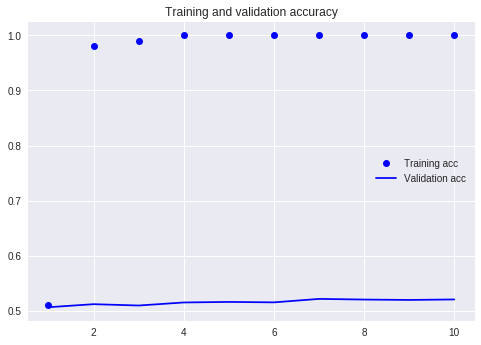

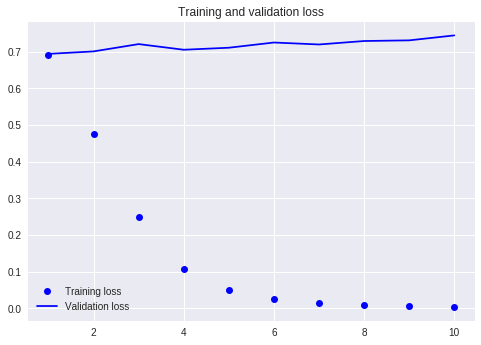

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

検証データでの正解率は50%台前半。学習済みの単語埋め込みを使用する方が少し性能はいい。    
学習に使用するサンプルを増やすと、変わるでしょう。とのこと。    

最後にテストデータで評価してみる。

In [0]:
#テストデータセットのデータをトークン化
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [32]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 3s 106us/step


[0.8774755236816406, 0.55544]

正解率は54%でデータが少ないとうまく言ってない。